# Data-driven modeling of a Resistance-Capacitance network with Neural ODEs

This tutorial performs the data-driven modeling of a network of capacitive agents that are coupled by resistive connections.


**Energy balance in dissipative systems**

In many physical systems, behaviors over time are driven by input-output energy balances as prescribed by the [First Law of Thermodynamics](https://en.wikipedia.org/wiki/First_law_of_thermodynamics); i.e.:
$$
\Delta U = Q - W,
$$
where $U$ is internal energy, $Q$ is heat added to the system, and $W$ is work done by the system on it surroundings. This energy accounting scheme can be extended to many situations. For example, suppose we wish to track the temperature ($T$) of a system with some thermal capacity ($C$) through time ($t$). After recasting internal energy as $U = C \cdot T$, this yields a time-dependent form of the First Law of Thermodynamics:
$$
\frac{dT}{dt} = \frac{1}{C}\left( \dot{Q} - \dot{W} \right),
$$
with the heating and work terms now in units of power. This provides a compact framework for analysis of the time dynamics of systems that interact with their surroundings through heating and/or mechanical work. 

Here, we're concerned with systems comprised of many interacting *capacitive agents* - that is, a network of agents with a First Law of Thermodynamics input/output energy balance. This is the foundation for many engineering applications, such as building thermal dynamics. Each closed volume in a building has some thermal capacitance and is coupled via heat flows - through walls, heating, ventilation, air conditioning, etc. - with other capacitive agents. The couplings between capacitive agents are analogous to resistors in a circuit, acting to dissipate power across its connection points. An isolated capacitive agent subject to resistive energy transfer forms a [resistance-capacitance ciruit, or *RC Ciruit*](https://en.wikipedia.org/wiki/RC_circuit). Many coupled agents form a *RC Network*.

A resistively-driven single zone RC agent obeys the First Law energy balance as:
$$
\frac{dT}{dt} = \frac{1}{C} \left( \frac{1}{R}\left( T_{ext} - T \right) \right),
$$
where $T_{ext}$ is the forcing temperature. Note that no work is performed by the system on its surroundings. In the networked setting, the resistive couplings are summed over all of the connections for each agent in the network:
$$
\frac{dT_i}{dt} = \frac{1}{C_i} \left( A_{i,j} \sum_j^n  \frac{1}{R_{i,j}} \left( T_j - T_i \right)  \right),
$$
where $n$ is the number of agents in the network, $i,j \in \{1, 2, \dots , n\}$,  $A_{i,j}$ is the $(0,1)$-*adjacency matrix* defining the network structure (pairwise connections), and $R_{i,j}$ is the resistance for the pairwise interaction.

### References
[1] [Ricky T. Q. Chen, Yulia Rubanova, Jesse Bettencourt, David Duvenaud, Neural Ordinary Differential Equations, NeurIPS 2018](https://arxiv.org/abs/1806.07366)  
[2] [Christopher Rackauckas, Yingbo Ma, Julius Martensen, Collin Warner, Kirill Zubov, Rohit Supekar, Dominic Skinner, Ali Ramadhan, Alan Edelman, Universal Differential Equations for Scientific Machine Learning, arXiv:2001.04385](https://arxiv.org/abs/2001.04385)  
[3] [L. Di Natale, B. Svetozarevic, P. Heer, C.N. Jones,
Physically Consistent Neural Networks for building thermal modeling: Theory and analysis,
Applied Energy, Volume 325, 2022](https://www.sciencedirect.com/science/article/pii/S0306261922010819)  
[4] [J. Koch, Z. Chen, A. Tuor, J. Drgona, D. Vrabie; Structural inference of networked dynamical systems with universal differential equations. Chaos 1 February 2023](https://pubs.aip.org/aip/cha/article-abstract/33/2/023103/2875955/Structural-inference-of-networked-dynamical?redirectedFrom=fulltext)

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

**Modeling with NeruoMANCER**

Our task is to leverage the known structure of RC networks to estimate capacitances and coupling resistivities from data. We will use the NeruoMANCER package for this task; let's do our imports:

In [1]:
# Numpy + plotting utilities + ordered dicts
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


# Standard PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Neuromancer imports
from neuromancer.psl.coupled_systems import *
from neuromancer.dynamics import integrators, ode, physics, interpolation
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss
from neuromancer.system import Node, System
from neuromancer.loggers import BasicLogger
from neuromancer.trainer import Trainer

# Fix seeds for reproducibility
np.random.seed(200)
torch.manual_seed(0)


**Data Generation**

Let's generate some data from a 5-zone RC network using NeuroMANCER's built-in RC-Network simulator. First we define a graph structure for our RC network as an array of pairwise connections and then hand this to PSL's RC Network class. A notional diagram of the network is shown below: 5 agents are coupled in a network, all five are connected to an outdoor temperature and a unique heating source.

![RC-Net diagram](../ODEs/figs/rc_net.png)

In [2]:
adj = np.array([[0,1],[0,2],[0,3],[1,0],[1,3],[1,4],[2,0],[2,3],[3,0],[3,1],[3,2],[3,4],[4,1],[4,3]]).T
s = RC_Network(nx=5, adj=adj)
nsim = 500
sim, s_dev, s_test = [s.simulate(nsim=nsim) for _ in range(3)]


We can quickly take a look at the evolution of zonal temperatures over the length of the timeseries:

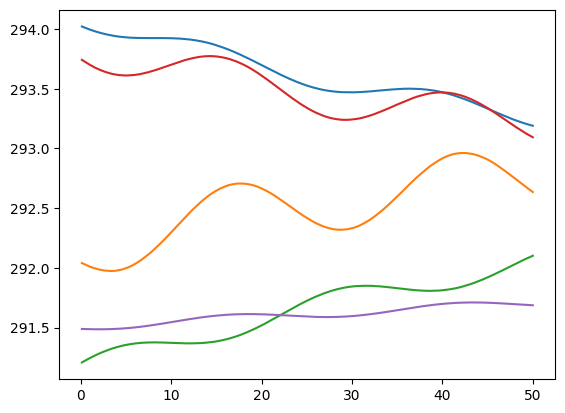

In [3]:
plt.plot(sim['Time'],sim['X'])

And also the external inputs to the system:

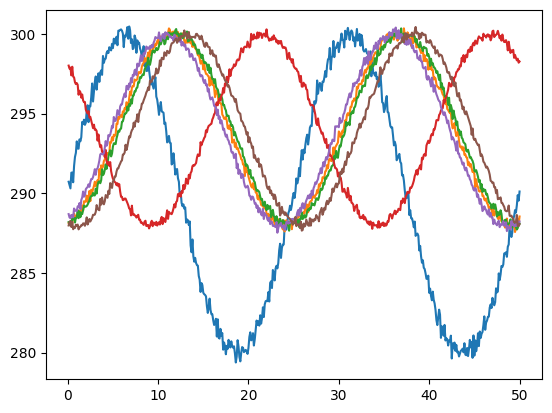

In [4]:
plt.plot(sim['Time'],sim['U'])

Datasets are handled by PyTorch DataLoaders viw DictDatasets:

In [5]:
nstep = 10

train_data = {'Y': sim['Y'], 'X': sim['X'], 'U': sim['U']}
dev_data = {'Y': s_dev['Y'], 'X': s_dev['X'], 'U': s_dev['U']}
test_data = {'Y': s_test['Y'], 'X': s_test['X'], 'U': s_test['U']}
for d in [train_data, dev_data]:
    d['X'] = d['X'].reshape(nsim//nstep, nstep, 5)
    d['Y'] = d['Y'].reshape(nsim//nstep, nstep, 5)
    d['U'] = d['U'].reshape(nsim//nstep, nstep, 6)
    d['xn'] = d['X'][:, 0:1, :]

train_dataset, dev_dataset, = [DictDataset(d, name=n) for d, n in zip([train_data, dev_data], ['train', 'dev'])]
train_loader, dev_loader, test_loader = [DataLoader(d, batch_size=nsim//nstep, collate_fn=d.collate_fn, shuffle=True) for d in [train_dataset, dev_dataset, dev_dataset]]


# Model Construction

Now that we have our data ready to go, let's construct our model for the RC Network system. We have many options for modeling such systems ranging from completely data-driven methods (like Dynamic Mode Decomposition), to data-driven equation-based methods (like Neural ODEs or Sparse Identification of Nonlinear Dynamics). Here, we wish to leverage the known structure of the system to construct a parameter-tuning problem in NeuroMANCER. To that end, we need to create our 5-zone ``building'' and all of the resistive connections that make up the network.


**Agents** 

At the core of a networked dynamical system, we define *agents* as objects possessing a dynamical state that evolves according to an Ordinary Differential Equation (ODE). These can be rooms in a building, a drone in a swarm, etc. In this case, we wish to create five capacitive agents to represent our building from our dataset. Here, we define the zones to be a list of 5 `RCNode`, each with a trainable parameter $C$ - the capacitance for the agent, and a scaling factor. This scaling factor is useful for including if you have prior knowledge of the approximate time constant for the agent.

In [6]:
zones = [physics.RCNode(C=nn.Parameter(torch.tensor(5.0)),scaling=1.0e-5) for i in range(5)]  # heterogeneous population w/ identical physics

Each zone in this network has its own heater. We include these heaters in the model via a `SourceSink` node - essentially a placeholder object for connecting our zones to external inputs.

In [7]:
heaters = [physics.SourceSink() for i in range(5)] # define heaters

Lastly, each zone is also in contact with the ambient environment (the outdoors). We represent outside as an additional `SourceSink` agent and then concatenate these lists:

In [8]:
outside = [physics.SourceSink()]  

# join lists:
agents = zones + heaters + outside

Before we connect our agents together in a graph, we need to define a mapping between our agents in the list and the indices of their respective states in the dataset. For this, we use a quick helper function:

In [9]:
map = physics.map_from_agents(agents)
# Let's take a look at this 'map':
print(map)

[OrderedDict([('T', 0)]), OrderedDict([('T', 1)]), OrderedDict([('T', 2)]), OrderedDict([('T', 3)]), OrderedDict([('T', 4)]), OrderedDict([('T', 5)]), OrderedDict([('T', 6)]), OrderedDict([('T', 7)]), OrderedDict([('T', 8)]), OrderedDict([('T', 9)]), OrderedDict([('T', 10)])]


**Couplings**

From our instantiation of the PSL RC-Network, we already have an adjacency list corresponding to the connections among the 5 zones in our building. To avoid the tedium of individually constructing resistive connections between these agents, let's use a helper function to do it for us:

In [10]:
# Helper function for constructing couplings based on desired edge physics and an edge list:
def generate_parameterized_edges(physics,edge_list):
    """
    Quick helper function to construct edge physics/objects from adj. list:
    """

    couplings = []
    if isinstance(physics,nn.Module): # is "physics" an instance or a class?
        # If we're in here, we expect one instance of "physics" for all edges in edge_list (homogeneous edges)
        physics.pins = edge_list
        couplings.append(physics)
        print(f'Broadcasting {physics} to all elements in edge list.')
    else: 
        # If we're in here, we expect different "physics" for each edge in edge_list (heterogeneous edges)
        for edge in edge_list:
            agent = physics(R=nn.Parameter(torch.tensor(50.0)),pins=[edge])
            couplings.append(agent)

        print(f'Assuming new {physics} for each element in edge list.')

    return couplings

couplings = generate_parameterized_edges(physics.DeltaTemp,list(adj.T))    # Heterogeneous edges of same physics

# What do we have so far?
print(len(couplings))
# Let's take a look at one:
print(couplings[0])
# What's it connecting?
print(couplings[0].pins)


Assuming new <class 'neuromancer.dynamics.physics.DeltaTemp'> for each element in edge list.
14
DeltaTemp()
[array([0, 1])]


Next, we need to add connections between our `SourceSink` agents (the outdoors and the heaters) and the `RCNode` agents with more `DeltaTemp` resistive connections. These are easier to bookkeep, so let's do it manually. Here, the pins argument is expecting a list of arrays that specify pairwise interactions in the format (sender, receiver). Be sure that this order is consistent, especially when defining custom agents and couplings.

In [11]:
# Couple w/ outside temp:
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[0,5]]))
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[1,5]]))
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[2,5]]))
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[3,5]]))
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[4,5]]))

# Couple w/ individual sources:
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[0,6]]))
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[1,7]]))
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[2,8]]))
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[3,9]]))
couplings.append(physics.DeltaTemp(R=nn.Parameter(torch.tensor(50.0)),pins=[[4,10]]))

We're ready to define our ODE System, integrator, and dynamics model:

In [12]:
model_ode = ode.GeneralNetworkedODE(
    map = map,
    agents = agents,
    couplings = couplings,
    insize = s.nx+s.nu,
    outsize = s.nx,
    inductive_bias="compositional")

fx_int = integrators.RK2(model_ode, h=1.0)

dynamics_model = System([Node(fx_int,['xn','U'],['xn'])])

**Loss and problem definitions**

We define our loss to be a simple Mean-Squared Error between the reference trajectories ($X^{j}(t)$) and model trajectories ($\hat{X}^{j}(t)$) evaluated at the collocation points $i$ for each $j$-batch:
$$
\mathcal{L} = \frac{1}{N_i \cdot N_k} \left( \sum_i \sum_j \left( X^{j}(t_i) - \hat{X}^{j}(t_i) \right)^2\right)
$$

In [13]:
x = variable("X")
xhat = variable("xn")[:, :-1, :]

reference_loss = ((xhat == x)^2)
reference_loss.name = "ref_loss"

objectives = [reference_loss]
constraints = []

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)

# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

optimizer = torch.optim.Adam(problem.parameters(), lr=0.01)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=["dev_loss","train_loss"])

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    epochs=1000,
    patience=20,
    warmup=5,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
)

None
Number of parameters: 29


**Training**

In [14]:
best_model = trainer.train()

epoch: 0	train_loss: 0.01284	dev_loss: 0.05561	eltime:  0.25205
epoch: 1	train_loss: 0.01278	dev_loss: 0.05536	eltime:  0.57704
epoch: 2	train_loss: 0.01272	dev_loss: 0.05510	eltime:  0.84812
epoch: 3	train_loss: 0.01266	dev_loss: 0.05485	eltime:  1.12015
epoch: 4	train_loss: 0.01260	dev_loss: 0.05460	eltime:  1.37500
epoch: 5	train_loss: 0.01254	dev_loss: 0.05435	eltime:  1.67538
epoch: 6	train_loss: 0.01248	dev_loss: 0.05410	eltime:  1.93220
epoch: 7	train_loss: 0.01242	dev_loss: 0.05385	eltime:  2.20841
epoch: 8	train_loss: 0.01236	dev_loss: 0.05360	eltime:  2.49175
epoch: 9	train_loss: 0.01231	dev_loss: 0.05335	eltime:  2.87653
epoch: 10	train_loss: 0.01225	dev_loss: 0.05310	eltime:  3.13448
epoch: 11	train_loss: 0.01219	dev_loss: 0.05285	eltime:  3.37705
epoch: 12	train_loss: 0.01213	dev_loss: 0.05260	eltime:  3.66636
epoch: 13	train_loss: 0.01207	dev_loss: 0.05236	eltime:  3.92337
epoch: 14	train_loss: 0.01201	dev_loss: 0.05211	eltime:  4.16764
epoch: 15	train_loss: 0.01196	dev_l

epoch: 125	train_loss: 0.00683	dev_loss: 0.02988	eltime:  34.37020
epoch: 126	train_loss: 0.00680	dev_loss: 0.02972	eltime:  34.67126
epoch: 127	train_loss: 0.00676	dev_loss: 0.02957	eltime:  34.97128
epoch: 128	train_loss: 0.00672	dev_loss: 0.02941	eltime:  35.25646
epoch: 129	train_loss: 0.00669	dev_loss: 0.02925	eltime:  35.55663
epoch: 130	train_loss: 0.00665	dev_loss: 0.02910	eltime:  35.86611
epoch: 131	train_loss: 0.00662	dev_loss: 0.02894	eltime:  36.15563
epoch: 132	train_loss: 0.00658	dev_loss: 0.02879	eltime:  36.45009
epoch: 133	train_loss: 0.00655	dev_loss: 0.02864	eltime:  36.73547
epoch: 134	train_loss: 0.00651	dev_loss: 0.02848	eltime:  37.03905
epoch: 135	train_loss: 0.00648	dev_loss: 0.02833	eltime:  37.29043
epoch: 136	train_loss: 0.00644	dev_loss: 0.02818	eltime:  37.57691
epoch: 137	train_loss: 0.00641	dev_loss: 0.02803	eltime:  37.82912
epoch: 138	train_loss: 0.00637	dev_loss: 0.02788	eltime:  38.12300
epoch: 139	train_loss: 0.00634	dev_loss: 0.02773	eltime:  38.4

epoch: 248	train_loss: 0.00342	dev_loss: 0.01492	eltime:  68.18342
epoch: 249	train_loss: 0.00340	dev_loss: 0.01483	eltime:  68.48374
epoch: 250	train_loss: 0.00338	dev_loss: 0.01474	eltime:  68.81218
epoch: 251	train_loss: 0.00336	dev_loss: 0.01465	eltime:  69.16226
epoch: 252	train_loss: 0.00334	dev_loss: 0.01456	eltime:  69.41832
epoch: 253	train_loss: 0.00332	dev_loss: 0.01448	eltime:  69.72552
epoch: 254	train_loss: 0.00330	dev_loss: 0.01439	eltime:  70.01123
epoch: 255	train_loss: 0.00328	dev_loss: 0.01430	eltime:  70.35928
epoch: 256	train_loss: 0.00326	dev_loss: 0.01422	eltime:  70.63747
epoch: 257	train_loss: 0.00324	dev_loss: 0.01413	eltime:  70.88626
epoch: 258	train_loss: 0.00322	dev_loss: 0.01404	eltime:  71.16334
epoch: 259	train_loss: 0.00320	dev_loss: 0.01396	eltime:  71.44031
epoch: 260	train_loss: 0.00318	dev_loss: 0.01387	eltime:  71.71130
epoch: 261	train_loss: 0.00316	dev_loss: 0.01379	eltime:  71.94129
epoch: 262	train_loss: 0.00314	dev_loss: 0.01371	eltime:  72.2

epoch: 371	train_loss: 0.00159	dev_loss: 0.00678	eltime:  102.71918
epoch: 372	train_loss: 0.00157	dev_loss: 0.00673	eltime:  103.05053
epoch: 373	train_loss: 0.00156	dev_loss: 0.00669	eltime:  103.35064
epoch: 374	train_loss: 0.00155	dev_loss: 0.00664	eltime:  103.65029
epoch: 375	train_loss: 0.00154	dev_loss: 0.00660	eltime:  103.95542
epoch: 376	train_loss: 0.00153	dev_loss: 0.00655	eltime:  104.27494
epoch: 377	train_loss: 0.00152	dev_loss: 0.00651	eltime:  104.57393
epoch: 378	train_loss: 0.00151	dev_loss: 0.00646	eltime:  104.88587
epoch: 379	train_loss: 0.00150	dev_loss: 0.00642	eltime:  105.22287
epoch: 380	train_loss: 0.00149	dev_loss: 0.00637	eltime:  105.59353
epoch: 381	train_loss: 0.00148	dev_loss: 0.00633	eltime:  105.89910
epoch: 382	train_loss: 0.00147	dev_loss: 0.00629	eltime:  106.25237
epoch: 383	train_loss: 0.00146	dev_loss: 0.00624	eltime:  106.55005
epoch: 384	train_loss: 0.00146	dev_loss: 0.00620	eltime:  106.91189
epoch: 385	train_loss: 0.00145	dev_loss: 0.00616

epoch: 492	train_loss: 0.00070	dev_loss: 0.00283	eltime:  140.39838
epoch: 493	train_loss: 0.00069	dev_loss: 0.00281	eltime:  140.65523
epoch: 494	train_loss: 0.00069	dev_loss: 0.00279	eltime:  140.90967
epoch: 495	train_loss: 0.00068	dev_loss: 0.00276	eltime:  141.17639
epoch: 496	train_loss: 0.00068	dev_loss: 0.00274	eltime:  141.41587
epoch: 497	train_loss: 0.00068	dev_loss: 0.00272	eltime:  141.68151
epoch: 498	train_loss: 0.00067	dev_loss: 0.00270	eltime:  141.95799
epoch: 499	train_loss: 0.00067	dev_loss: 0.00268	eltime:  142.21123
epoch: 500	train_loss: 0.00066	dev_loss: 0.00266	eltime:  142.49338
epoch: 501	train_loss: 0.00066	dev_loss: 0.00264	eltime:  142.74029
epoch: 502	train_loss: 0.00065	dev_loss: 0.00262	eltime:  143.03596
epoch: 503	train_loss: 0.00065	dev_loss: 0.00260	eltime:  143.28625
epoch: 504	train_loss: 0.00064	dev_loss: 0.00258	eltime:  143.55206
epoch: 505	train_loss: 0.00064	dev_loss: 0.00256	eltime:  143.87128
epoch: 506	train_loss: 0.00063	dev_loss: 0.00254

epoch: 613	train_loss: 0.00031	dev_loss: 0.00110	eltime:  174.02928
epoch: 614	train_loss: 0.00031	dev_loss: 0.00109	eltime:  174.30111
epoch: 615	train_loss: 0.00030	dev_loss: 0.00108	eltime:  174.55258
epoch: 616	train_loss: 0.00030	dev_loss: 0.00107	eltime:  174.81226
epoch: 617	train_loss: 0.00030	dev_loss: 0.00106	eltime:  175.06884
epoch: 618	train_loss: 0.00030	dev_loss: 0.00105	eltime:  175.35346
epoch: 619	train_loss: 0.00030	dev_loss: 0.00104	eltime:  175.66118
epoch: 620	train_loss: 0.00029	dev_loss: 0.00104	eltime:  175.92931
epoch: 621	train_loss: 0.00029	dev_loss: 0.00103	eltime:  176.18870
epoch: 622	train_loss: 0.00029	dev_loss: 0.00102	eltime:  176.46677
epoch: 623	train_loss: 0.00029	dev_loss: 0.00101	eltime:  176.76456
epoch: 624	train_loss: 0.00029	dev_loss: 0.00100	eltime:  177.00998
epoch: 625	train_loss: 0.00028	dev_loss: 0.00100	eltime:  177.23793
epoch: 626	train_loss: 0.00028	dev_loss: 0.00099	eltime:  177.50067
epoch: 627	train_loss: 0.00028	dev_loss: 0.00098

epoch: 734	train_loss: 0.00015	dev_loss: 0.00044	eltime:  206.02104
epoch: 735	train_loss: 0.00015	dev_loss: 0.00043	eltime:  206.30315
epoch: 736	train_loss: 0.00015	dev_loss: 0.00043	eltime:  206.54920
epoch: 737	train_loss: 0.00015	dev_loss: 0.00043	eltime:  206.83912
epoch: 738	train_loss: 0.00015	dev_loss: 0.00043	eltime:  207.12326
epoch: 739	train_loss: 0.00015	dev_loss: 0.00042	eltime:  207.38113
epoch: 740	train_loss: 0.00015	dev_loss: 0.00042	eltime:  207.65434
epoch: 741	train_loss: 0.00015	dev_loss: 0.00042	eltime:  207.91924
epoch: 742	train_loss: 0.00015	dev_loss: 0.00041	eltime:  208.20083
epoch: 743	train_loss: 0.00015	dev_loss: 0.00041	eltime:  208.43994
epoch: 744	train_loss: 0.00015	dev_loss: 0.00041	eltime:  208.68937
epoch: 745	train_loss: 0.00015	dev_loss: 0.00041	eltime:  208.94244
epoch: 746	train_loss: 0.00015	dev_loss: 0.00040	eltime:  209.18879
epoch: 747	train_loss: 0.00015	dev_loss: 0.00040	eltime:  209.57858
epoch: 748	train_loss: 0.00015	dev_loss: 0.00040

epoch: 855	train_loss: 0.00010	dev_loss: 0.00022	eltime:  237.43531
epoch: 856	train_loss: 0.00010	dev_loss: 0.00022	eltime:  237.67844
epoch: 857	train_loss: 0.00010	dev_loss: 0.00022	eltime:  237.92329
epoch: 858	train_loss: 0.00010	dev_loss: 0.00022	eltime:  238.15753
epoch: 859	train_loss: 0.00010	dev_loss: 0.00022	eltime:  238.41388
epoch: 860	train_loss: 0.00010	dev_loss: 0.00022	eltime:  238.67046
epoch: 861	train_loss: 0.00010	dev_loss: 0.00022	eltime:  238.93211
epoch: 862	train_loss: 0.00010	dev_loss: 0.00022	eltime:  239.18363
epoch: 863	train_loss: 0.00010	dev_loss: 0.00022	eltime:  239.44034
epoch: 864	train_loss: 0.00010	dev_loss: 0.00021	eltime:  239.70462
epoch: 865	train_loss: 0.00010	dev_loss: 0.00021	eltime:  239.97068
epoch: 866	train_loss: 0.00010	dev_loss: 0.00021	eltime:  240.22337
epoch: 867	train_loss: 0.00010	dev_loss: 0.00021	eltime:  240.47104
epoch: 868	train_loss: 0.00010	dev_loss: 0.00021	eltime:  240.73506
epoch: 869	train_loss: 0.00010	dev_loss: 0.00021

epoch: 976	train_loss: 0.00009	dev_loss: 0.00016	eltime:  268.35431
epoch: 977	train_loss: 0.00009	dev_loss: 0.00016	eltime:  268.63941
epoch: 978	train_loss: 0.00009	dev_loss: 0.00016	eltime:  268.89738
epoch: 979	train_loss: 0.00009	dev_loss: 0.00016	eltime:  269.17488
epoch: 980	train_loss: 0.00009	dev_loss: 0.00016	eltime:  269.45078
epoch: 981	train_loss: 0.00009	dev_loss: 0.00016	eltime:  269.70418
epoch: 982	train_loss: 0.00009	dev_loss: 0.00016	eltime:  269.96026
epoch: 983	train_loss: 0.00009	dev_loss: 0.00016	eltime:  270.21789
epoch: 984	train_loss: 0.00009	dev_loss: 0.00016	eltime:  270.49751
epoch: 985	train_loss: 0.00009	dev_loss: 0.00016	eltime:  270.73008
epoch: 986	train_loss: 0.00009	dev_loss: 0.00016	eltime:  271.00640
epoch: 987	train_loss: 0.00009	dev_loss: 0.00016	eltime:  271.26856
epoch: 988	train_loss: 0.00009	dev_loss: 0.00016	eltime:  271.57694
epoch: 989	train_loss: 0.00009	dev_loss: 0.00016	eltime:  271.84506
epoch: 990	train_loss: 0.00009	dev_loss: 0.00016

**Visualization**

How did we do? Let's do a quick n-step rollout of the timeseries and compare with the test data:

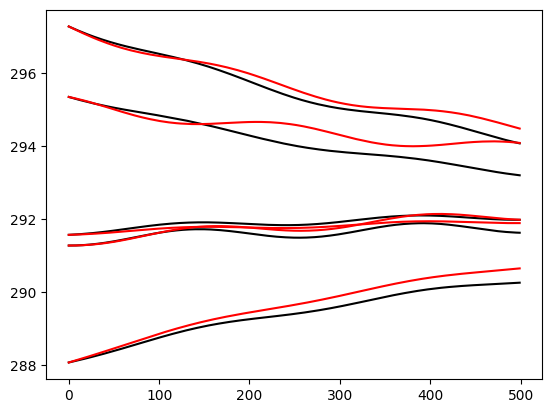

In [15]:
u = torch.from_numpy(s_test['U']).float()
sol = torch.zeros((500,5))
ic = torch.tensor(s_test['X'][0,:5])
for j in range(sol.shape[0]-1):
    if j==0:
        sol[[0],:] = ic.float()
        sol[[j+1],:] = fx_int(sol[[j],:],u[[j],:])
    else:
        sol[[j+1],:] = fx_int(sol[[j],:],u[[j],:])

plt.plot(sol.detach().numpy(),label='model', color = 'black')
plt.plot(s_test['X'][:,:5],label = 'data', color = 'red')